# TP : apprentissage multimodal


Dans ce TP, nous allons utiliser le modèle d'apprentissage, FashionCLIP, pré-entraîné sur des images ainsi que des descriptions en langage naturel. Plus particulièrement, nous allons considérer deux cas d'usage :

*   **Moteur de recherche d'images :** il s'agit de trouver, à partir d'une requête en langage naturel, l'image correspondante.

*   **Classification zero-shot :** il s'agit simplement de construire un classifieur d'images (faire correspondre un label à une image).



## Dataset

Nous allons dans un premier temps télécharger les données. Celles-ci provienennt de [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).

In [1]:
# %%capture
# !pip install gdown
# !gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
# !unzip data

### Modèle FashionCLIP

Nous allons également télécharger le modèle pré-entraîné.

In [2]:
# %%capture
# !pip install -U fashion-clip

In [36]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
%%capture
fclip = FashionCLIP('fashion-clip')

FashionCLIP, à l'instar de CLIP, crée un espace vectoriel partagé pour les images et le texte. Cela permet de nombreuses applications, telles que la recherche (trouver l'image la plus similaire à une requête donnée) ou la classification zero-shot.

Il y a principalement deux composants : un encodeur d'image (pour générer un vecteur à partir d'une image) et un encodeur de texte (pour générer un vecteur à partir d'un texte).










<img src="https://miro.medium.com/v2/resize:fit:1400/0*FLNMtW6jK51fm7Og"  width="400">



Nous allons télécharger les données que nous allons ensuite nettoyer.

In [5]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# Supprimer les éléments ayant la même description
subset = articles.drop_duplicates("detail_desc").copy()

# Supprimer les images dont la catégorie n'est pas renseignée
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# Garder seulement les descriptions dont la longueur est inférieure à 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# Supprimer les articles qui ne sont pas suffisamment fréquents dans le jeu de données
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

subset.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,176754003,176754,2 Row Braided Headband (1),74,Hair/alice band,Accessories,1010016,Solid,17,Yellowish Brown,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two-strand hairband with braids in imitation s...
3,189634031,189634,Long Leg Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Leggings in stretch jersey with an elasticated...


In [6]:
subset.to_csv("subset_data.csv", index=False)
f"Il y a {len(subset)} éléments dans le dataset"

'Il y a 3104 éléments dans le dataset'

## Moteur de recherche d'images

Constuire un moteur de recherche qui permet, à partir d'une description en langage naturel, de récupérer l'image correspondante. Mesurer ses performances (précision).

<img src="https://miro.medium.com/v2/resize:fit:1400/1*cnKHgLAumVyuHuK9pkqr7A.gif"  width="800">


In [18]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

In [7]:
# Créer les représentations vectorielles (embeddings) des images et des descriptions.
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

100%|██████████| 97/97 [01:43<00:00,  1.07s/it]


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [00:09<00:00,  9.75it/s]


In [20]:
print(image_embeddings.shape)
print(text_embeddings.shape)
print(len(images))
print(len(texts))

(3104, 512)
(3104, 512)
3104
3104


In [62]:
def search_image_by_desc(queries, text_embeddings, images):
   """
      Looking for the most similar images to the queries
   """
   query_embeddings = fclip.encode_text(queries, batch_size=32)
   
   most_similar_indxs = [np.argmax(np.dot(query_embedding, text_embeddings.T)) for query_embedding in query_embeddings]

   most_similar_images = [images[idx] for idx in most_similar_indxs]
   return most_similar_images

Jersey top with narrow shoulder straps.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 102.19it/s]


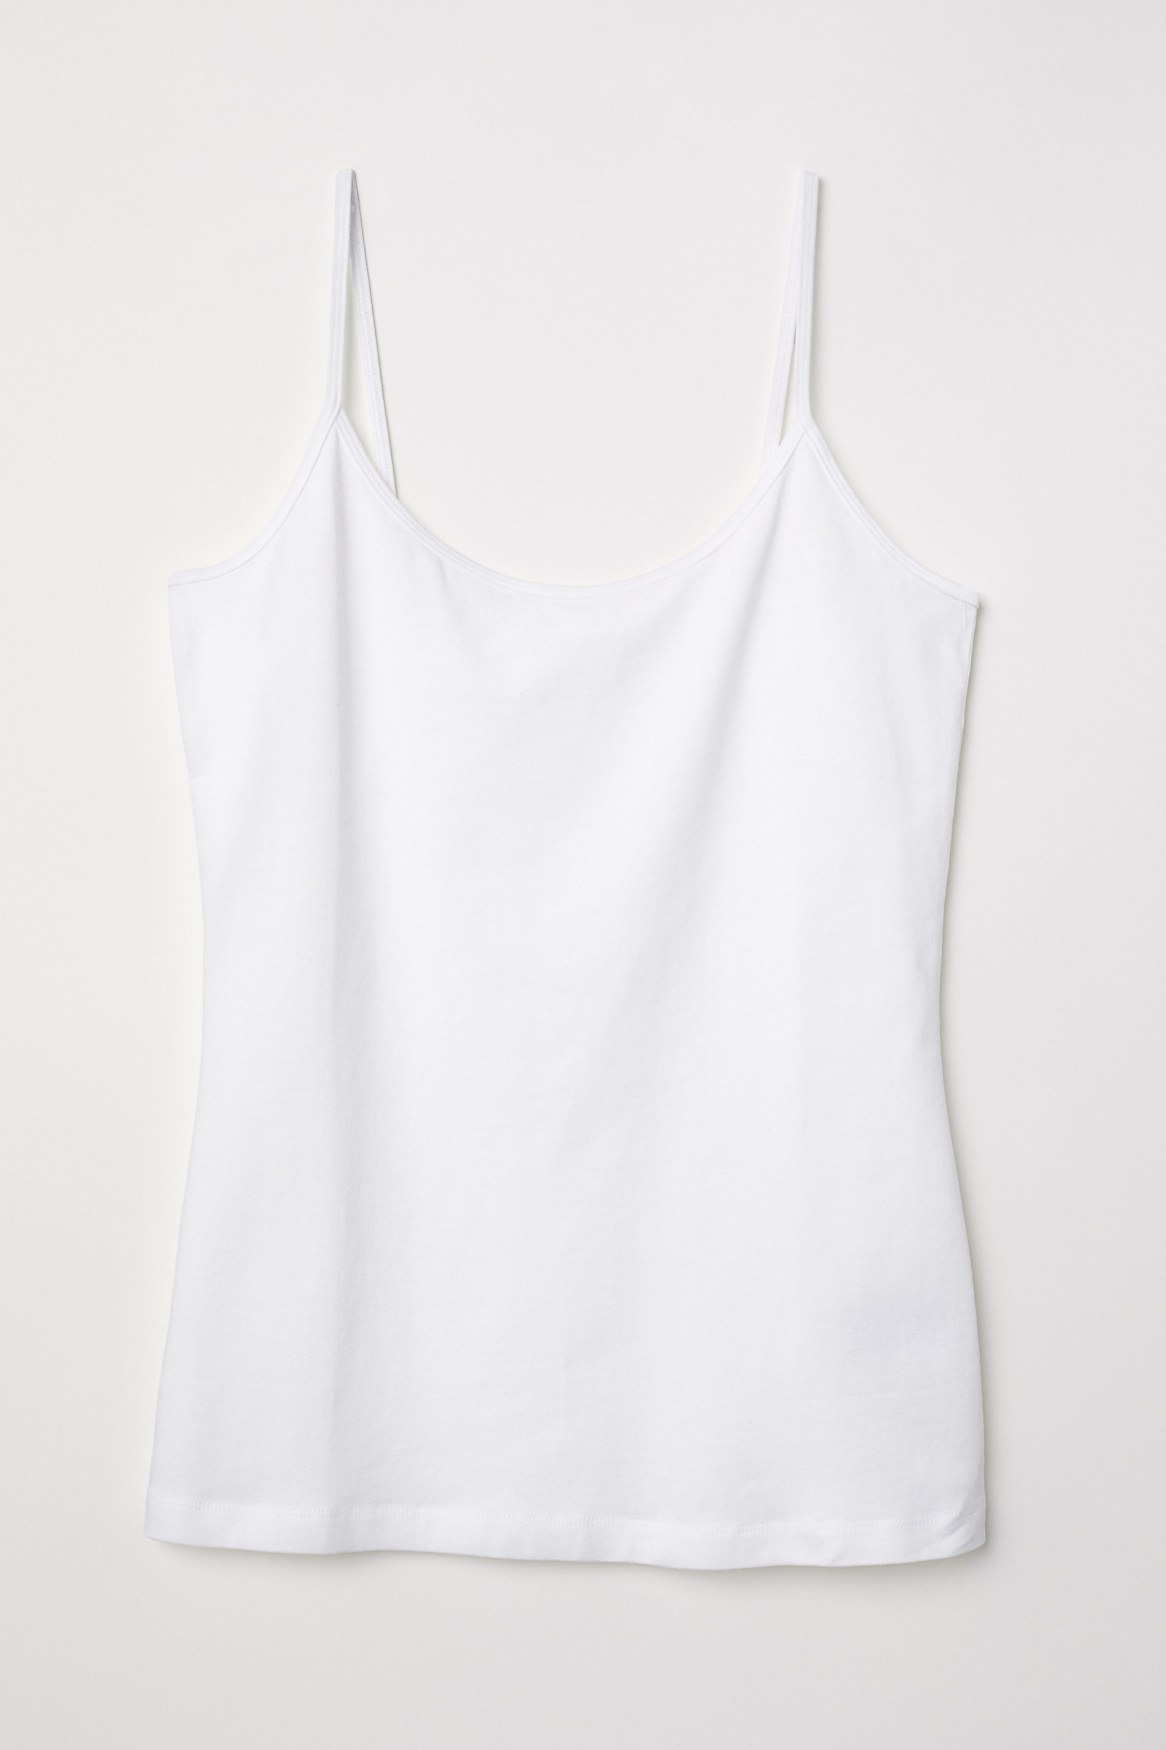

In [63]:
from IPython.display import Image, display

query = subset.iloc[0]['detail_desc']
print(query)
corresponding_image = search_image_by_desc([query], text_embeddings, images)[0]
display(Image(corresponding_image, width=300, height=200))

Leggings in stretch jersey with an elasticated waist.


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 89.82it/s]


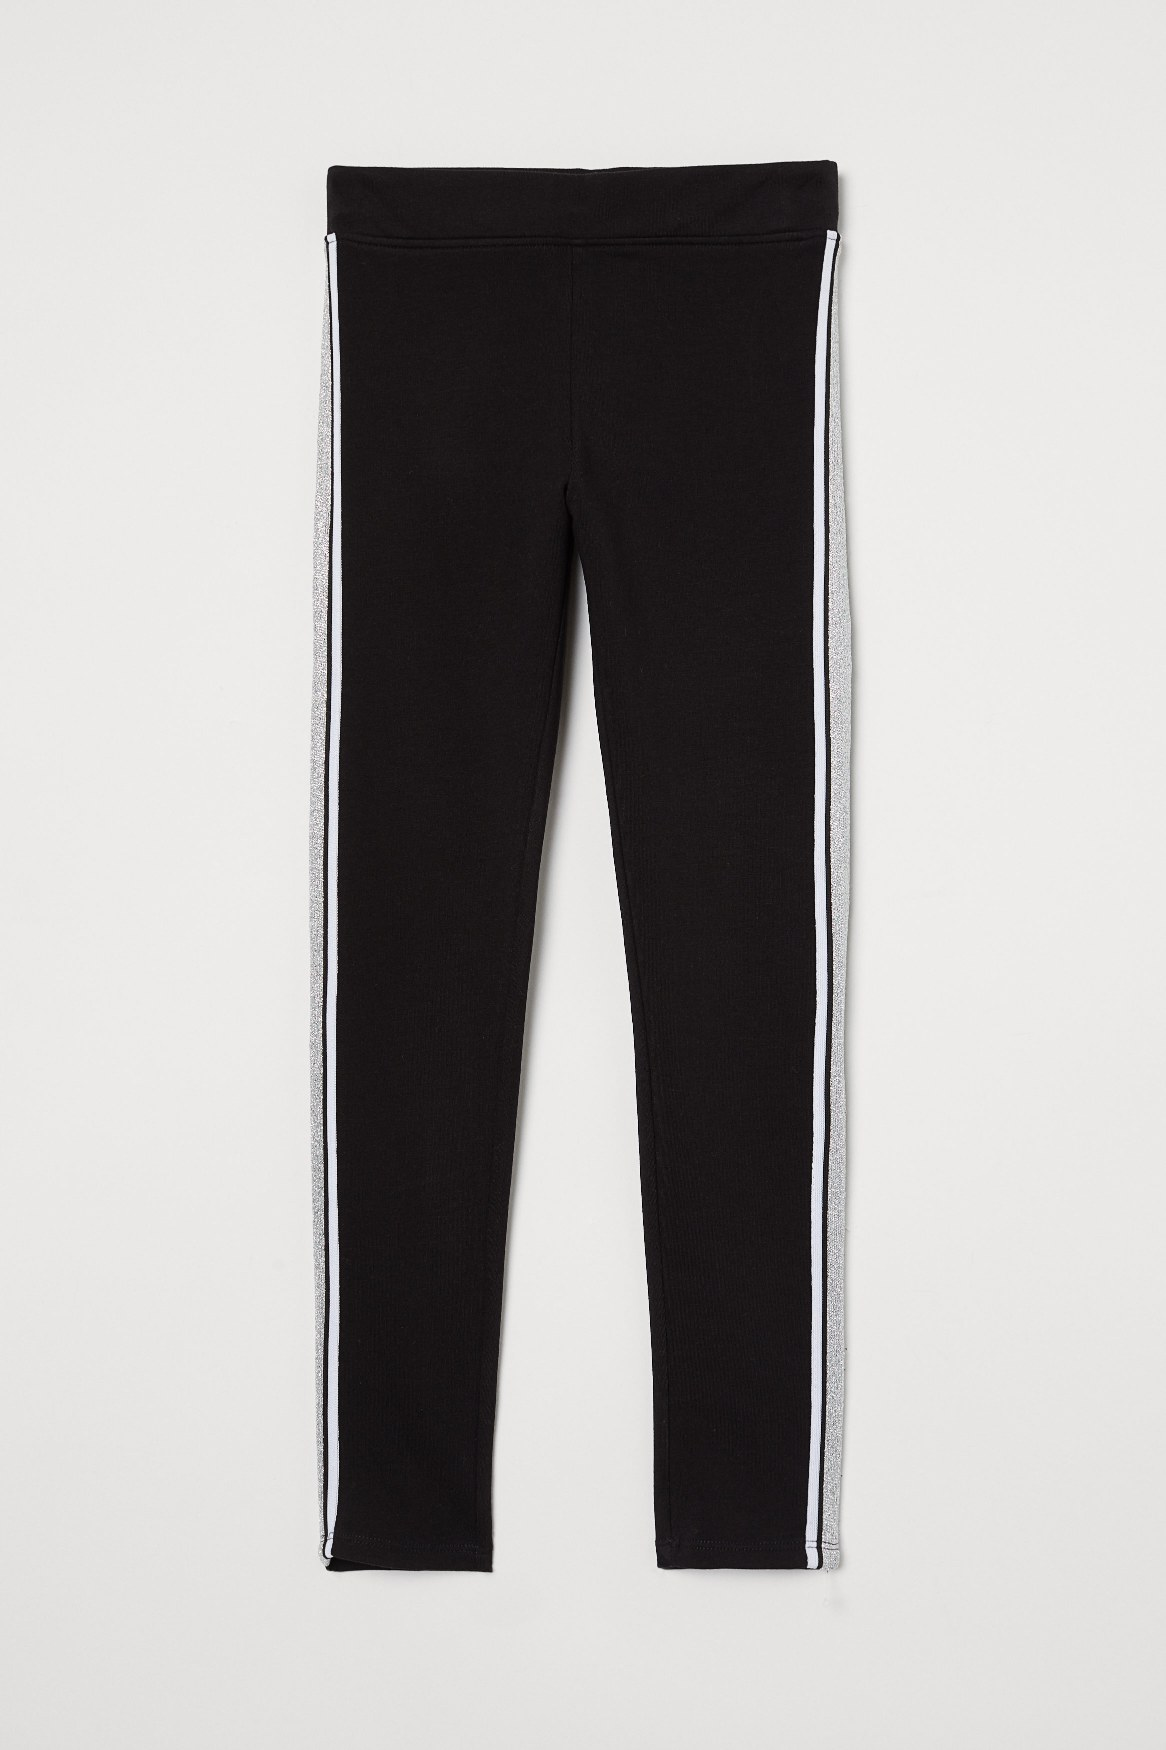

Here the wrong image is found


In [79]:
query = subset.iloc[2]['detail_desc']
print(query)
corresponding_image = search_image_by_desc([query], text_embeddings, images)[0]
display(Image(corresponding_image, width=300, height=200))
print('Here the wrong image is found')

N.B: Ne pas préciser la couleur de l'article ça ne sert à rien pour query.  
Regardons la précision du moteur de recherche en reprenant les descriptions embeddings.

In [78]:
queries = subset['detail_desc'].tolist()
most_similar_images = search_image_by_desc(queries, text_embeddings, images)

# Get article_id from image path
article_ids = np.array([int(image.split("/")[-1].split(".")[0]) for image in most_similar_images])

# Top-1 precision
top1_precision = np.mean(article_ids == subset["article_id"].tolist())
print(f"Top-1 precision: {top1_precision}")

# Top-5 precision
queries_embeddings = fclip.encode_text(queries, batch_size=32)
# Get the 5 most similar indices for each query
five_most_similar_indices = np.argsort(cosine_similarity(queries_embeddings, text_embeddings), axis=1)[:,-5:]

# Get article_id from image path
five_most_similar_article_ids = np.array([[int(images[idx].split("/")[-1].split(".")[0]) for idx in five_most_similar_indices[i]] for i in range(len(queries))])

# Top-5 precision
top5_precision = np.mean([article_ids[i] in five_most_similar_article_ids[i] for i in range(len(queries))])
print(f"Top-5 precision: {top5_precision}")

Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [00:09<00:00,  9.79it/s]


Top-1 precision: 0.8414948453608248


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [00:09<00:00,  9.83it/s]


Top-5 precision: 0.9288015463917526


'\n# Trouver les indices des embeddings texte les plus similaires\nmost_similar_indices = np.argmax(similarities, axis=0)\n\n# Top-1 precision\ntop1_precision = np.mean(most_similar_indices == np.arange(len(text_embeddings)))\nprint(f"Top-1 precision: {top1_precision}")\n\n\n# Top-5 precision \nfive_most_similar_indices = np.argsort(similarities, axis=0)[-5:].T\n\ntop5_precision = np.mean([i in five_most_similar_indices[i] for i in range(len(text_embeddings))])\nprint(f"Top-5 precision: {top5_precision}")'

# Classification zero-shot  

La classification zéro shot (zero-shot classification en anglais) fait référence à un type de tâche d'apprentissage automatique où un modèle est capable de classer des exemples qui n'ont pas été inclus dans l'ensemble d'entraînement initial. En d'autres termes, le modèle doit effectuer une classification sur des données qu'il n'a jamais vues auparavant.  

Construite un classsifieur d'images (prédire le label d'une image). Mesurer ses performances.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*No6ZONpQMIcfFaNMOI5oNw.gif"  width="800">



In [80]:
def search_desc_by_images(images, image_embeddings, texts):
   """
      Looking for the most similar images to the queries
   """
   embeddings = fclip.encode_images(images, batch_size=32)
   
   most_similar_indxs = [np.argmax(np.dot(image_embedding, image_embeddings.T)) for image_embedding in embeddings]

   most_similar_texts = [texts[idx] for idx in most_similar_indxs]
   return most_similar_texts

1it [00:00, 34.59it/s]

Leggings in stretch jersey with an elasticated waist.


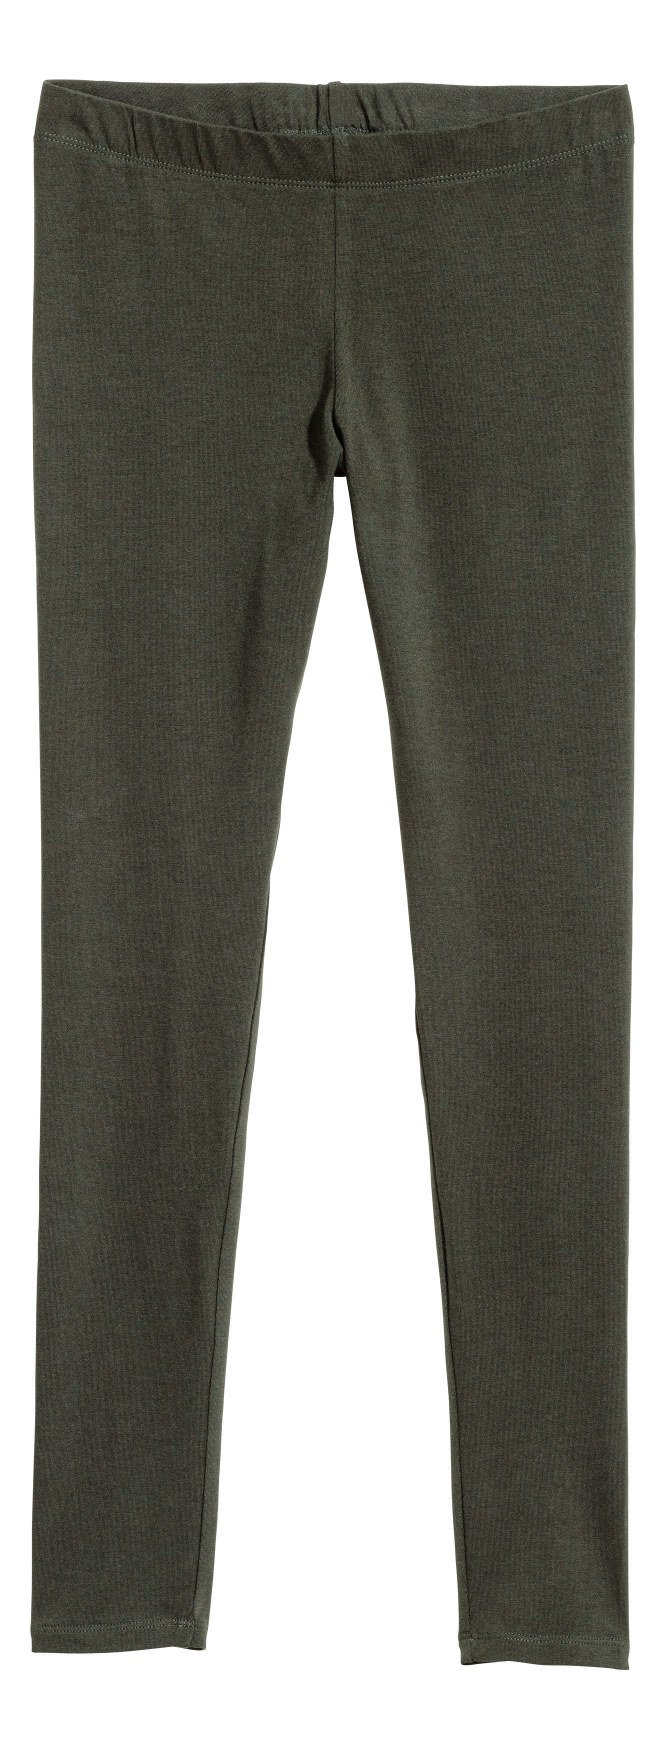

In [81]:
image = ["data_for_fashion_clip/189634031.jpg"]
corresponding_text = search_desc_by_images(image, image_embeddings, texts)[0]
print(corresponding_text)
display(Image(image[0], width=300, height=200))

Mesurons la précision du classifieur en reprenant les images embeddings.

In [84]:
similarities = np.dot(image_embeddings, image_embeddings.T)
most_similar_indices = np.argmax(similarities, axis=0)

# Top-1 precision
top1_precision = np.mean(most_similar_indices == np.arange(len(image_embeddings)))
print(f"Top-1 precision: {top1_precision}")

# Top-5 precision 
five_most_similar_indices = np.argsort(similarities, axis=0)[-5:].T

top5_precision = np.mean([i in five_most_similar_indices[i] for i in range(len(image_embeddings))])
print(f"Top-5 precision: {top5_precision}")

Top-1 precision: 1.0
Top-5 precision: 1.0
